In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms
import numpy as np
import math

from tqdm.notebook import tqdm

# Dataset: RotationMNIST

In [2]:
class RotatingMNIST:
    class Rotate(object):
        def __call__(self, img):
            out = transforms.functional.rotate(img, self.angle)
            return out

        def __repr__(self):
            return self.__class__.__name__
    
    def __init__(self):
        global count
        super(RotatingMNIST, self).__init__()

        data_root = "mnist"
        self.rotater = self.Rotate()

        train_dataset = datasets.MNIST(
            data_root,
            train=True,
            download=True,
            transform=transforms.Compose(
                [
                    transforms.Grayscale(3),
                    self.rotater,
                    transforms.Grayscale(1),
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,)),
                ]
            ),
        )
        self.train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=128, shuffle=True
        )
        self.val_loader = torch.utils.data.DataLoader(
            datasets.MNIST(
                data_root,
                train=False,
                transform=transforms.Compose(
                    [
                        transforms.Grayscale(3),
                        self.rotater,
                        transforms.Grayscale(1),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)),
                    ]
                ),
            ),
            batch_size=128,
            shuffle=False
        )

    def update_task(self, i):
        # The num of tasks to learn is 36
        self.rotater.__setattr__('angle', i * (360 // 36))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw


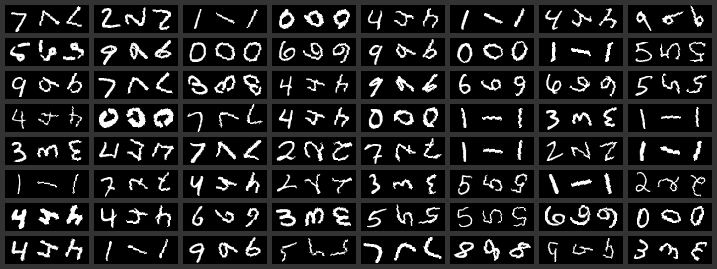

In [3]:
rot_mnist = RotatingMNIST()

rot_mnist.update_task(0)
task0, labels = next(iter(rot_mnist.val_loader))
rot_mnist.update_task(8)
task8, labels = next(iter(rot_mnist.val_loader))
rot_mnist.update_task(17)
task17, labels = next(iter(rot_mnist.val_loader))

torchvision.transforms.ToPILImage()(
    torchvision.utils.make_grid(
        torch.cat([task0, task8, task17], dim=-1)[:64],
        normalize=True,
        padding=5,
        pad_value=0.2
    )
)

# Model: FlyNet - A fly-circuit-like single-hidden-layer network
## This model is from [Learning to Modulate Random Weights: Neuromodulation-inspired Neural Networks For Efficient Continual Learning](https://arxiv.org/abs/2204.04297)

In [7]:
class FlyNet(nn.Module):
    def __init__(self, width_mult=10, num_tasks=1):
        super(FlyNet, self).__init__()
        input_dim = 28 * 28
        self.encoder = FlyNetEncoder(n_in=input_dim, n_out=int(width_mult * input_dim))
        self.decoder = ModularNet(int(width_mult * input_dim), 10, num_tasks=num_tasks, kernel_size=1, stride=1, bias=False)

    def forward(self, x, cv=None):
        out = x.squeeze()
        out = self.encoder(out)
        out = torch.nn.ReLU()(out)
        out = self.decoder(out, cv)
        return out.squeeze()

    def get_context_vectors(self):
        cvs = self.decoder.get_contexts()
        random_strs = self.decoder.get_random_strength()
        context_vectors = []
        for cv, rs in zip(cvs, random_strs):
            context_vectors.append(cv * rs)
        return context_vectors
    
    def get_last_weight(self):
        return self.decoder.get_weight()
    
    def get_flyhash(self):
        return self.encoder.get_flyhash()        


class FlyNetEncoder(nn.Module):
    def __init__(self, n_in, n_out, num_glom_inputs=7):
        super(FlyNetEncoder, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.num_glom_inputs = num_glom_inputs
        self.flyhash = nn.Parameter(self.generate_sparse_weight(), requires_grad=False)

    def generate_sparse_weight(self):
        weight = np.zeros((self.n_out, self.n_in))
        for i in range(self.n_out):
            final_num_input = np.clip(self.num_glom_inputs, 1, self.n_in).item()
            indices = np.random.choice(self.n_in, final_num_input, replace=False)
            weight[i, indices] = 1.
        return torch.from_numpy(weight).float()

    def forward(self, x):
        num_samples = x.size()[0]
        m = torch.mm(x.view(num_samples, -1), torch.transpose(self.flyhash, 0, 1))
        r = torch.relu(m - torch.mean(m, dim=1, keepdim=True))
        return r
    
    def get_flyhash(self):
        return self.flyhash

    
class ModularNet(nn.Conv2d):
    def __init__(self, *args, num_tasks=1, **kwargs):
        super().__init__(*args, **kwargs)
        # Learning Params.
        # 1. context vectors
        self.contexts = nn.ParameterList(
            [
                nn.Parameter(
                    torch.nn.init.xavier_normal_(
                        torch.Tensor(self.in_channels, 1)
                    )
                )
                for _ in range(num_tasks)
            ]
        )

        # 2. random strength
        self.random_strength = nn.ParameterList(
            [
                nn.Parameter(
                    torch.nn.init.xavier_normal_(
                        torch.Tensor(1, 1)
                    )
                )
                for _ in range(num_tasks)
            ]
        )
        # Kernels are non-learnable
        self.weight.requires_grad = False

    def forward(self, x, cv=None):
        x = x.squeeze()
        if cv is None:
            out = x * self.contexts[self.task].squeeze()
            random_strength = self.random_strength[self.task].squeeze()
            weight = random_strength * self.weight.squeeze()
        else:
            out = x * cv.squeeze()
            weight = self.weight.squeeze()
        out = out.mm(weight.t())
        out = out.view(*out.size(), 1, 1)
        return out

    def get_contexts(self):
        return self.contexts

    def get_random_strength(self):
        return self.random_strength
    
    def get_weight(self):
        return self.weight

In [8]:
# Utility functions
def set_model_task(model, task, verbose=True):
    for n, m in model.named_modules():
        if isinstance(m, ModularNet):
            if verbose:
                print(f"=> Set task of {n} to {task}")
            m.task = task

# Training

In [9]:
def train(model, trainloader, optimizer, epoch, cv=None):
    model.train()

    criterion = nn.CrossEntropyLoss()
    num_correct = 0
    total_seen = 0
    for i, (batch, labels) in tqdm(
        enumerate(trainloader),
        ascii=True,
        total=len(trainloader)
    ):
        logits = model(batch, cv=cv)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 20 == 0:
            predictions = logits.argmax(dim=-1)
            num_correct += (predictions == labels).float().sum()
            total_seen += logits.size(0) 
            tqdm.write(
                (f"e{epoch} {i+1}/{len(trainloader)}"
                f" => Loss {loss.item():0.4f}, "
                f"Acc@1 {(num_correct / total_seen):0.4f}"),
                end="\r"
            )

@torch.no_grad()
def evaluate(model, val_loader, epoch, cv=None):
    model.eval()
    num_correct = 0
    total_seen = 0
    for batch, labels in tqdm(
        val_loader,
        ascii=True,
        total=len(val_loader)
    ):
        logits = model(batch, cv=cv)
        predictions = logits.argmax(dim=-1)
        num_correct += (predictions == labels).float().sum()
        total_seen += logits.size(0) 
    

    tqdm.write(
        f"Val Perf after {epoch + 1} epochs "
        f"Acc@1 {(num_correct / total_seen):0.4f}", 
    )
    return num_correct / total_seen

In [10]:
# Task ID given during train time
from IPython.display import clear_output

data_mnist = rot_mnist # perm_mnist or rot_mnist
num_tasks = 5 # For simplicity, we set the number of tasks to 5. Originally, 36.
model = FlyNet(width_mult=10, num_tasks=num_tasks)
task_vectors_before = [i.detach().numpy() for i in model.get_context_vectors()]

for task in range(num_tasks):
    print(f"Training for task {task}")
    set_model_task(model, task)
    data_mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in model.parameters() if p.requires_grad], lr=1e-2)
    # Train with a single epoch for simplicity, but originally, 3 epochs are set.
    for e in range(1):
        train(model, data_mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(model, data_mnist.val_loader, e)
    # Freeze the learned parameters
    for n, p in model.named_parameters():
        split = n.split(".")
        if split[-2] in [
                 "random_strength",  # learnable params from modular net
                 "contexts"  # learnable params from modular net
                 ] and split[-1] == str(task):
            p.requires_grad = False
        
task_vectors_after = [i.detach().numpy() for i in model.get_context_vectors()]

Training for task 0
=> Set task of decoder to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2596, Acc@1 0.8724


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9360
Training for task 1
=> Set task of decoder to 1


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.1484, Acc@1 0.8740


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9365
Training for task 2
=> Set task of decoder to 2


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2462, Acc@1 0.8753


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9324
Training for task 3
=> Set task of decoder to 3


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2966, Acc@1 0.8750


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9321
Training for task 4
=> Set task of decoder to 4


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2444, Acc@1 0.8704


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9317


In [11]:
for task in range(num_tasks):
    print(f"Testing for task {task}")
    set_model_task(model, task)
    data_mnist.update_task(task)

    print("Test")
    print("============")
    acc1 = evaluate(model, data_mnist.val_loader, 0)

Testing for task 0
=> Set task of decoder to 0
Test


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9360
Testing for task 1
=> Set task of decoder to 1
Test


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9365
Testing for task 2
=> Set task of decoder to 2
Test


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9324
Testing for task 3
=> Set task of decoder to 3
Test


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9321
Testing for task 4
=> Set task of decoder to 4
Test


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9317


# Task Similarity

In [12]:
from scipy import spatial

def compute_cosine_sim_mat(context_vectors, num_tasks):
    cosine_sim_mat = np.zeros(shape=(num_tasks, num_tasks))
    for i in range(num_tasks):
        for j in range(num_tasks):
            cosine_sim_mat[i, j] = 1 - spatial.distance.cosine(context_vectors[i].squeeze(), context_vectors[j].squeeze())
    return cosine_sim_mat

task_sim_mat_before = compute_cosine_sim_mat(task_vectors_before, num_tasks)
task_sim_mat_after = compute_cosine_sim_mat(task_vectors_after, num_tasks)

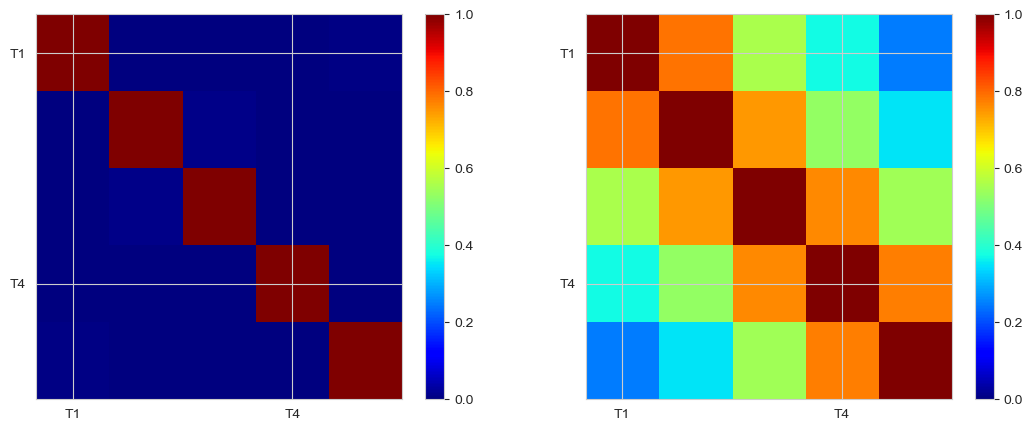

In [13]:
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# create figure
fig = plt.figure(figsize=(13, 5))

# setting values to rows and column variables
rows = 1
columns = 2
gap = 3

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# Before training
plt.imshow(task_sim_mat_before, vmin=0, vmax=1, cmap='jet', aspect='auto')
plt.xticks(range(0, num_tasks, gap), ["T{}".format(i) for i in range(1, num_tasks+1, gap)])
plt.yticks(range(0, num_tasks, gap), ["T{}".format(i) for i in range(1, num_tasks+1, gap)])
plt.colorbar()

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
# After training
plt.imshow(task_sim_mat_after, vmin=0, vmax=1, cmap='jet', aspect='auto')
plt.xticks(range(0, num_tasks, gap), ["T{}".format(i) for i in range(1, num_tasks+1, gap)])
plt.yticks(range(0, num_tasks, gap), ["T{}".format(i) for i in range(1, num_tasks+1, gap)])
plt.colorbar()
plt.show()

In [14]:
# Task Geometry Sensitive Hashing Property
rot_mnist.update_task(0)
task0, _ = next(iter(rot_mnist.val_loader))
seven_t0_rep = (torch.nn.ReLU()(model.encoder(task0[0])) * task_vectors_after[0].squeeze()).squeeze()
three_t0_rep = (torch.nn.ReLU()(model.encoder(task0[4])) * task_vectors_after[0].squeeze()).squeeze()

print(f'sim between seven and three in task0: {1 - spatial.distance.cosine(seven_t0_rep, three_t0_rep)}')

rot_mnist.update_task(1)
task4, _ = next(iter(rot_mnist.val_loader))
seven_t4_rep = (torch.nn.ReLU()(model.encoder(task4[0])) * task_vectors_after[4].squeeze()).squeeze()
three_t4_rep = (torch.nn.ReLU()(model.encoder(task4[4])) * task_vectors_after[4].squeeze()).squeeze()
print(f'sim between seven and three in task4: {1 - spatial.distance.cosine(seven_t4_rep, three_t4_rep)}')

print(f'sim of sevens between t0 and t4: {1 - spatial.distance.cosine(seven_t0_rep, seven_t4_rep)}')
print(f'sim of three between t0 and t4: {1 - spatial.distance.cosine(three_t0_rep, three_t4_rep)}')

sim between seven and three in task0: 0.4222761392593384
sim between seven and three in task4: 0.4381292164325714
sim of sevens between t0 and t4: 0.1955752670764923
sim of three between t0 and t4: 0.2520766854286194


In [15]:
dict_task = {}
for t in range(num_tasks):
    set_model_task(model, t)
    rot_mnist.update_task(t)
    dict_task[t] = {}
    print(f'Task {t}')
    val_loader = rot_mnist.val_loader
    for i, (batch, labels) in tqdm(
        enumerate(val_loader),
        ascii=True,
        total=len(val_loader)
    ):
        batch_size = batch.size()[0]
        rep = (torch.nn.ReLU()(model.encoder(batch)) * task_vectors_after[t].squeeze()).squeeze()
        
        for j in range(batch_size):
            if not j in dict_task[t].keys():
                dict_task[t][j] = [rep[j]]
            else:
                dict_task[t][j].append(rep[j])

=> Set task of decoder to 0
Task 0


  0%|          | 0/79 [00:00<?, ?it/s]

=> Set task of decoder to 1
Task 1


  0%|          | 0/79 [00:00<?, ?it/s]

=> Set task of decoder to 2
Task 2


  0%|          | 0/79 [00:00<?, ?it/s]

=> Set task of decoder to 3
Task 3


  0%|          | 0/79 [00:00<?, ?it/s]

=> Set task of decoder to 4
Task 4


  0%|          | 0/79 [00:00<?, ?it/s]

In [16]:
import itertools

num_samples = 10

list_intra_dist = []
for t in range(num_tasks):
    for c1 in range(10):
        for c2 in range(c1+1, 10):
            for element in itertools.product(dict_task[t][c1][:num_samples], dict_task[t][c2][:num_samples]):
                list_intra_dist.append(1 - spatial.distance.cosine(element[0].numpy(), element[1].numpy()))

/Users/jhong53/opt/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot: ylabel='Density'>

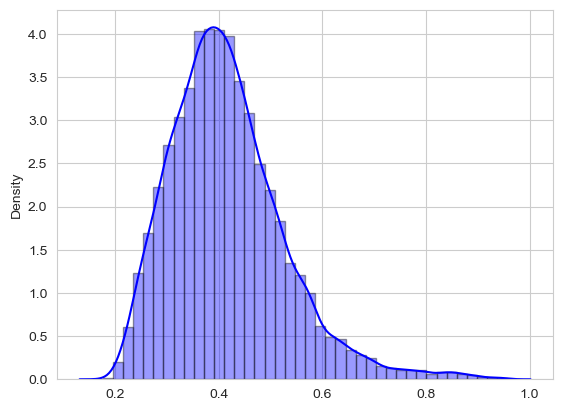

In [17]:
import seaborn as sns

sns.distplot(list_intra_dist, hist=True, kde=True, 
             bins=int(200/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

In [18]:
list_inter_dist = []

for t1 in range(num_tasks):
    for t2 in range(t1+1, num_tasks):
        for c in range(10):
            for element in itertools.product(dict_task[t1][c][:num_samples], dict_task[t2][c][:num_samples]):
                list_inter_dist.append(1 - spatial.distance.cosine(element[0].numpy(), element[1].numpy()))

/Users/jhong53/opt/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Cosine Distance')

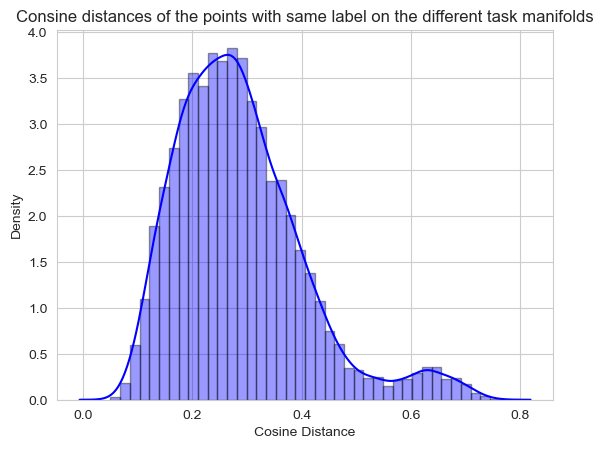

In [19]:
import matplotlib.pyplot as plt

sns.distplot(list_inter_dist, hist=True, kde=True, 
             bins=int(200/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

# Add labels
plt.title('Consine distances of the points with same label on the different task manifolds')
plt.xlabel('Cosine Distance')

/Users/jhong53/opt/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jhong53/opt/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


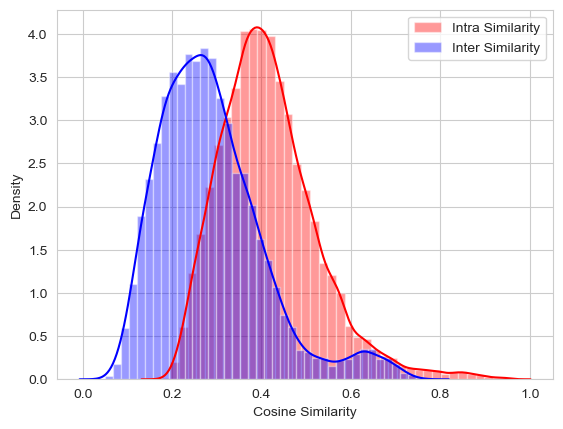

In [20]:
sns.distplot(list_intra_dist, hist=True, kde=True, 
             bins=int(200/5), color = 'red', label='Intra Similarity'
             )

sns.distplot(list_inter_dist, hist=True, kde=True, 
             bins=int(200/5), color = 'blue', label='Inter Similarity'
             )
plt.xlabel('Cosine Similarity')
plt.legend()
plt.show()

# Approximate Data Generating Process

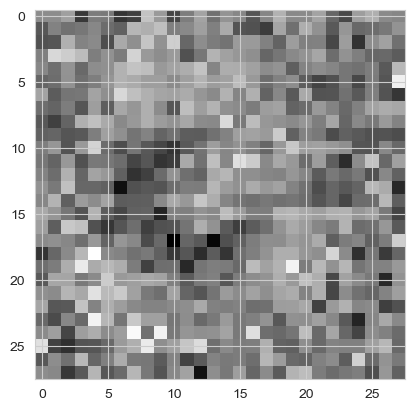

In [21]:
digit_3_classifier = model.decoder.weight[3].reshape(7840,-1) 
digit_3_classifier *= task_vectors_after[0].reshape(7840, 1)
sample = np.random.normal(loc=digit_3_classifier, scale=np.ones((7840, 1)) * 1/7840)
flyhash = np.linalg.pinv(model.encoder.get_flyhash().numpy())
recon_3 = np.matmul(flyhash, sample).reshape(28, 28)

plt.imshow(recon_3, cmap='gray')
plt.show()

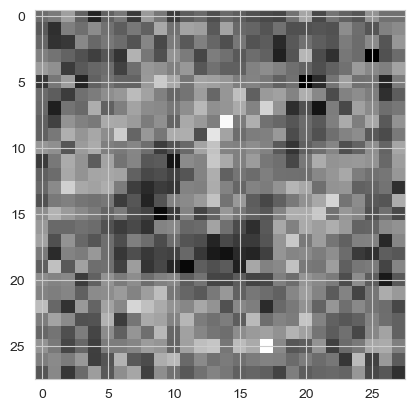

In [22]:
digit_3_classifier = model.decoder.weight[3].reshape(7840,-1) 
digit_3_classifier *= task_vectors_after[3].reshape(7840, 1)
sample = np.random.normal(loc=digit_3_classifier, scale=np.ones((7840, 1)) * 1/7840)
flyhash = np.linalg.pinv(model.encoder.get_flyhash().numpy())
recon_3 = np.matmul(flyhash, sample).reshape(28, 28)

plt.imshow(recon_3, cmap='gray')
plt.show()

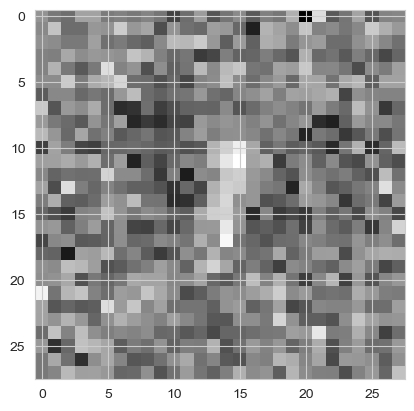

In [24]:
digit_1_classifier = model.decoder.weight[1].reshape(7840,-1) 
digit_1_classifier *= task_vectors_after[0].reshape(7840, 1)
sample = np.random.normal(loc=digit_1_classifier, scale=np.ones((7840, 1)) * 1/7840)
flyhash = np.linalg.pinv(model.encoder.get_flyhash().numpy())
recon_1 = np.matmul(flyhash, sample).reshape(28, 28)

plt.imshow(recon_1, cmap='gray')
plt.show()

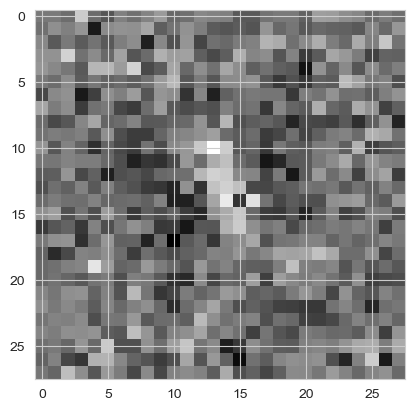

In [25]:
digit_1_classifier = model.decoder.weight[1].reshape(7840,-1) 
digit_1_classifier *= task_vectors_after[3].reshape(7840, 1)
sample = np.random.normal(loc=digit_1_classifier, scale=np.ones((7840, 1)) * 1/7840)
flyhash = np.linalg.pinv(model.encoder.get_flyhash().numpy())
recon_1 = np.matmul(flyhash, sample).reshape(28, 28)

plt.imshow(recon_1, cmap='gray')
plt.show()